In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#encoder-decoder class
class encoder_decoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(encoder_decoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.bottleneck_dim = bottleneck_dim

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [3]:
def add_gaussian_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return noisy_images

In [4]:
def calculate_ssim(images1, images2):
    ssim_score = 0
    for img1, img2 in zip(images1, images2):
        ssim_score += ssim(img1.squeeze().detach().numpy(), img2.squeeze().detach().numpy())
    return ssim_score / len(images1)


In [5]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed = model(data)
        loss = criterion(reconstructed, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(train_loader.dataset)

In [6]:
def evaluate(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        reconstructed_images = []
        original_images = []
        for data, _ in test_loader:
            data = data.to(device)
            reconstructed = model(data)
            reconstructed_images.append(reconstructed)
            original_images.append(data)
        ssim_score = calculate_ssim(original_images, reconstructed_images)
    return ssim_score

100%|██████████| 9912422/9912422 [00:00<00:00, 143028650.80it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 59351148.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 90142219.92it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 8647539.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Train Loss: 0.0317
Epoch 2, Train Loss: 0.0064
Epoch 3, Train Loss: 0.0044
Epoch 4, Train Loss: 0.0035
Epoch 5, Train Loss: 0.0031
SSIM score for sigma=0.1: 0.9793
Epoch 1, Train Loss: 0.0305
Epoch 2, Train Loss: 0.0063
Epoch 3, Train Loss: 0.0044
Epoch 4, Train Loss: 0.0035
Epoch 5, Train Loss: 0.0031
SSIM score for sigma=0.5: 0.9787
Epoch 1, Train Loss: 0.0339
Epoch 2, Train Loss: 0.0068
Epoch 3, Train Loss: 0.0047
Epoch 4, Train Loss: 0.0038
Epoch 5, Train Loss: 0.0033
SSIM score for sigma=1.0: 0.9767


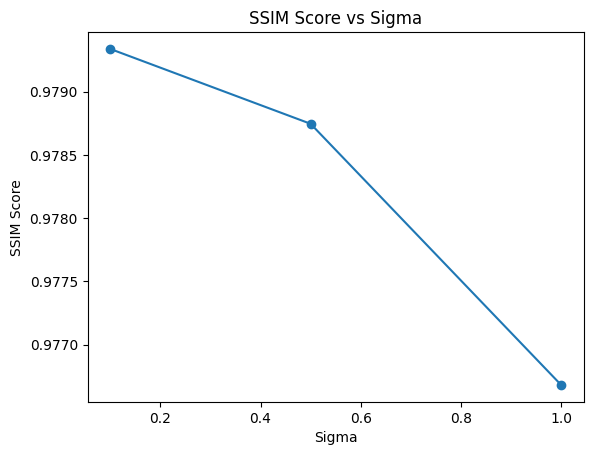

Epoch 1, Train Loss: 0.0333
Epoch 2, Train Loss: 0.0064
Epoch 3, Train Loss: 0.0045
Epoch 4, Train Loss: 0.0037
Epoch 5, Train Loss: 0.0033
SSIM score for bottleneck dim=8: 0.9777
Epoch 1, Train Loss: 0.0410
Epoch 2, Train Loss: 0.0072
Epoch 3, Train Loss: 0.0048
Epoch 4, Train Loss: 0.0038
Epoch 5, Train Loss: 0.0033
SSIM score for bottleneck dim=16: 0.9774
Epoch 1, Train Loss: 0.0302
Epoch 2, Train Loss: 0.0063
Epoch 3, Train Loss: 0.0042
Epoch 4, Train Loss: 0.0034
Epoch 5, Train Loss: 0.0030
SSIM score for bottleneck dim=32: 0.9794


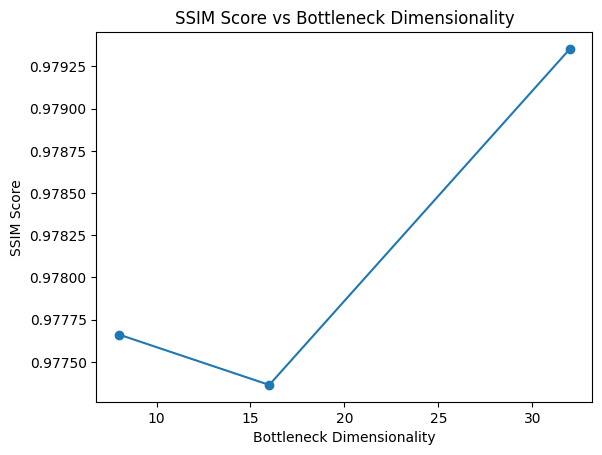

In [10]:
def main():
    #settng device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #loading MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

    #initializing parameters
    sigma_values = [0.1, 0.5, 1.0]  #different sigma values for Gaussian noise
    bottleneck_dims = [8, 16, 32]    #different bottleneck dimensionalities

    #list to store SSIM scores
    ssim_scores_sigma = []
    ssim_scores_dim = []

    #training and evaluation for varying sigma values
    for sigma in sigma_values:
        model = encoder_decoder(bottleneck_dim=16).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        for epoch in range(5):  #training for 5 epochs
            train_loss = train(model, train_loader, criterion, optimizer, device)
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

        ssim_score = evaluate(model, test_loader, device)
        ssim_scores_sigma.append(ssim_score)
        print(f"SSIM score for sigma={sigma}: {ssim_score:.4f}")

    plt.plot(sigma_values, ssim_scores_sigma, marker='o')
    plt.title('SSIM Score vs Sigma')
    plt.xlabel('Sigma')
    plt.ylabel('SSIM Score')
    plt.show()

    #training and evaluation for varying bottleneck dimensionalities
    for dim in bottleneck_dims:
        model = encoder_decoder(bottleneck_dim=dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        for epoch in range(5):  #training for 5 epochs
            train_loss = train(model, train_loader, criterion, optimizer, device)
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

        ssim_score = evaluate(model, test_loader, device)
        ssim_scores_dim.append(ssim_score)
        print(f"SSIM score for bottleneck dim={dim}: {ssim_score:.4f}")

    plt.plot(bottleneck_dims, ssim_scores_dim, marker='o')
    plt.title('SSIM Score vs Bottleneck Dimensionality')
    plt.xlabel('Bottleneck Dimensionality')
    plt.ylabel('SSIM Score')
    plt.show()

if __name__ == "__main__":
    main()
